# Gaia Catalog of Nearby Stars
Look at the very handy dataset for stars within ~100pc

Using the actual SN 1987A space,time coordinates, which nearby stars have seen the event? Which could have "responded"?

How do the uncertainties in LMC & Gaia distances propgate into time uncertainties for when stars should see the SNe?

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
# import astropy.coordinates as coord
from astropy import constants as const
from astropy import units as u
from astropy.time import Time
from astropy.table import Table

import sys
sys.path.append('/Users/james/Dropbox/python/cubehelix/')
import cubehelix

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
CMAP1 = cubehelix.cmap(start=0.5, rot=-0.6, sat=1.8, reverse=True)
CMAP2 = cubehelix.cmap(start=1.5, rot=-0.6, sat=1.8, reverse=True)

In [4]:
# SN 1987A Properties
t0 = Time({'year': 1987, 'month': 2, 'day': 23}, format='ymdhms')

c0_radec = SkyCoord.from_name('SN 1987A')

# Panagia (1999) https://ui.adsabs.harvard.edu/abs/1999IAUS..190..549P/abstract
d0 = 51.4 * u.kpc
d0_err= 1.2 * u.kpc

c0 = SkyCoord(ra=c0_radec.ra, dec=c0_radec.dec, distance=d0)

In [5]:
# https://arxiv.org/abs/2012.02061
GCNS_file = '../../lonely_stars/GCNS_cat.fits'
GCNS = Table.read(GCNS_file, format='fits')

# past me already did this, yay! 
# https://github.com/jradavenport/lonely_stars/blob/main/GCNS_KDTree.ipynb
c1 = SkyCoord(ra = GCNS['RA'] * u.degree,
              dec = GCNS['DEC'] * u.degree,
              distance= GCNS['DIST_50'] * u.kpc,
              frame='icrs')

len(GCNS)
# xyz = c1.transform_to(coord.Galactocentric)

331312

In [6]:
t1 = Time.now()
# t1 = Time({'year': 2088, 'month': 2, 'day': 23}, format='ymdhms')
dt = t1-t0

# dt.sec
# dt.jd
dt.to('year')

<Quantity 33.9493773 yr>

In [7]:
c = d0.to('lyr') / 2 # dist to foci from ellipse center
a = (((dt.to('s') * const.c) / 2) + c).to('lyr') # the semi-major axis of ellipse
print(a-c)

d1 = (GCNS['DIST_50'] * u.kpc) # dist to GCNS stars

# OMG, astropy does the 3D distance computation between coordinates!
# need to work out how to propogate errors here, but it's pretty rad...
d2 = c1.separation_3d(c0) # dist from GCNS to SN 1987A

16.97468865236442 lyr


In [8]:
# 2 things to compute for each GCNS object:
# 1. has it seen SN 1987A yet?
SNYES = d2.to('lyr').value <= (d0.to('lyr') + (dt.to('s') * const.c)).to('lyr').value
SNNO = ~SNYES

# 2. is it within the "SETI ellipse"?
EYES = (d1.to('lyr').value + d2.to('lyr').value) <= (2 * a.to('lyr').value)
ENO = ~EYES

In [9]:
# d2.to('lyr')
print(d0.to('lyr'), (dt.to('s') * const.c).to('lyr'))

167644.37814640606 lyr 33.949377304734135 lyr


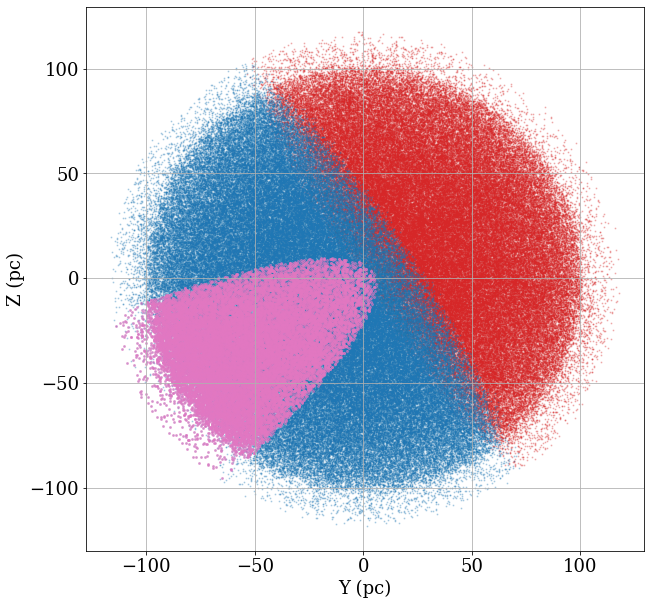

In [69]:
plt.figure(figsize=(10,10))
plt.scatter(GCNS['YCOORD_50'][SNNO], GCNS['ZCOORD_50'][SNNO], c='C3', s=1, alpha=0.25)
plt.scatter(GCNS['YCOORD_50'][SNYES], GCNS['ZCOORD_50'][SNYES], c='C0', s=1, alpha=0.25)

plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5)

plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')
plt.grid(True)
plt.savefig('GCNS_SN1987A.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [60]:
def echoxy0(t, c, Ntheta=1000, foci=False):

    a = 0.5 * (t + np.sqrt(t**2 + 4 * (c**2)))
    b = np.sqrt(0.5 * (t**2 + np.sqrt(t**4 + 4 * t**2 * c**2)))
    
    if foci:
        foci_length = np.sqrt(np.abs(a**2 - b**2))
        
        if a>=b:
            fx = np.array([-foci_length, foci_length])
            fy = np.array([0.,0.])
        if a<b:
            fx = np.array([0.,0.])
            fy = np.array([-foci_length, foci_length])
        return fx* u.lyr, fy* u.lyr

    else:
        theta = np.arange(0, 2*np.pi + 2*np.pi / Ntheta, 2*np.pi / Ntheta) # the angle about the origin

        x = a * np.cos(theta)
        y = b * np.sin(theta)
        return x * u.lyr, y * u.lyr

(-75.0, 75.0)

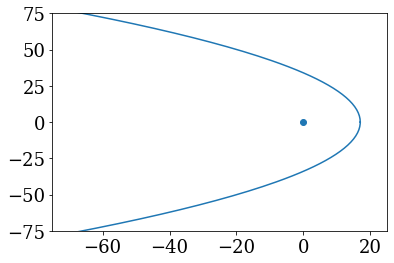

In [61]:
t=dt.to('year').value

fx0,fy0 = echoxy0(t, c.value, foci=True)
fx,fy = echoxy0(t, c.value, foci=False, Ntheta=10000)

plt.scatter((fx0 - fx0[1]), fy0)
plt.plot(fx - fx0[1], fy)
plt.xlim(-75,25)
plt.ylim(-75,75)

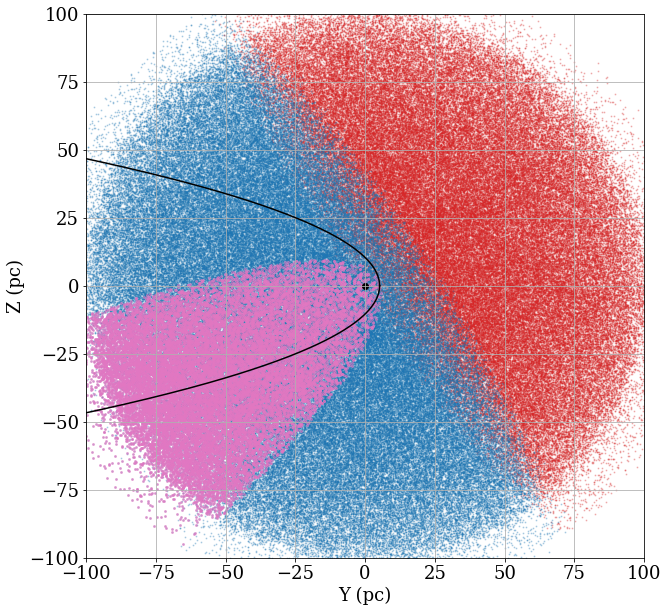

In [68]:
plt.figure(figsize=(10,10))
plt.scatter(GCNS['YCOORD_50'][SNNO], GCNS['ZCOORD_50'][SNNO], c='C3', s=1, alpha=0.25)
plt.scatter(GCNS['YCOORD_50'][SNYES], GCNS['ZCOORD_50'][SNYES], c='C0', s=1, alpha=0.25)

plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5)

plt.scatter((fx0 - fx0[1]).to('pc'), fy0.to('pc'), c='k')
plt.plot((fx - fx0[1]).to('pc'), fy.to('pc'), c='k')
plt.xlim(-100,100)
plt.ylim(-100,100)

plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')
plt.grid(True)
